In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, preps, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(preps)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_sign_selfeats = pd.read_csv(params.sign_featall_csv, index_col=0, parse_dates=True)[params.features_cols_tick + params.signals_cols_tick]
df_sign_selfeats = df_sign_selfeats[df_sign_selfeats.index.year >= params.init_df_year] ###########
df_sign_selfeats

,range_pct,atr_pct_7,atr_pct_28,time_afthour,time_premark,kc_w_20_20_2.0,bb_w_20_2p0,donch_w_20,ret_std_63,atr_pct_14,donch_w_55,ret_std_21,upper_shad,time_in_sess,dist_high_200,bb_w_50_2p0,lower_shad,time_hour,dist_low_200,time_week_of_year,trade_count,volume,atr_7_RZ,atr_14_RZ,atr_28_RZ,time_day_of_year,time_month,vol_spike_28,plus_di_28,stoch_k_14_3_3,rolling_max_close_200_RZ,adx_14,minus_di_28,minus_di_14,cci_20,plus_di_7,plus_di_14,adx_28,rsi_6,rolling_min_close_200_RZ,vol_spike_14,stoch_d_9_3_3,sma_5_RZ,minus_di_7,sma_21_RZ,sma_9_RZ,cci_14,sma_pct_200,stoch_k_9_3_3,cmf_14,close_raw,signal_raw,signal_thresh
2020-12-31 08:00:00,0.542954,0.179611,0.088732,0.0,1.0,0.102595,0.090002,0.115841,0.139730,0.122468,0.060489,0.230386,0.0000,0.0,0.066522,0.028942,0.000000,0.270833,0.007069,0.500000,0.002550,0.000234,0.446326,0.452637,0.414132,0.500000,0.416667,0.033347,0.402053,0.461282,0.60294,0.184634,0.456535,0.427611,0.119221,0.252371,0.333563,0.081782,0.276591,0.366904,0.033849,0.538291,0.482865,0.415002,0.447276,0.502435,0.108973,0.475250,0.461282,0.751227,133.560000,1.558898e-08,0.063077
2020-12-31 08:01:00,0.361843,0.233363,0.107583,0.0,1.0,0.127570,0.100127,0.115798,0.141450,0.155615,0.060463,0.233947,0.0000,0.0,0.055798,0.033313,0.000000,0.270833,0.018058,0.500000,0.002040,0.000170,0.572108,0.593658,0.537115,0.500000,0.416667,0.029998,0.305918,0.392883,0.60294,0.170553,0.350936,0.309395,0.232951,0.166325,0.238001,0.075984,0.360348,0.366904,0.029252,0.506859,0.396382,0.274279,0.424026,0.458333,0.236820,0.487457,0.392883,0.747974,133.606667,1.523993e-08,0.063077
2020-12-31 08:02:00,0.180858,0.248224,0.117011,0.0,1.0,0.139405,0.102794,0.115756,0.143089,0.169859,0.060437,0.237105,0.0000,0.0,0.045081,0.034731,0.000000,0.270833,0.029040,0.500000,0.001530,0.000106,0.607046,0.654431,0.598799,0.500000,0.416667,0.025275,0.262146,0.179418,0.60294,0.157478,0.302855,0.260681,0.333068,0.133704,0.198623,0.070394,0.438398,0.366904,0.024416,0.344528,0.328940,0.220930,0.414918,0.391994,0.338798,0.499617,0.179418,0.744203,133.653333,1.452162e-08,0.063077
2020-12-31 08:03:00,0.000000,0.229783,0.117362,0.0,1.0,0.138757,0.102794,0.115714,0.144665,0.166566,0.060411,0.239949,0.0000,0.0,0.034372,0.034855,0.000000,0.270833,0.040014,0.500000,0.001020,0.000041,0.564118,0.640690,0.601373,0.500000,0.416667,0.020719,0.248178,0.358836,0.60294,0.145337,0.287511,0.245491,0.425166,0.123519,0.186344,0.065003,0.510150,0.366904,0.020673,0.310379,0.307826,0.204273,0.416117,0.379466,0.417618,0.511717,0.358836,0.791758,133.700000,1.334189e-08,0.063077
2020-12-31 08:04:00,0.000000,0.234169,0.123431,0.0,1.0,0.145760,0.112237,0.115804,0.151128,0.174262,0.060466,0.251782,0.0000,0.0,0.057330,0.038973,0.000000,0.270833,0.016489,0.500000,0.003570,0.000509,0.573962,0.672842,0.640276,0.500000,0.416667,0.059034,0.220703,0.350293,0.60294,0.154419,0.392251,0.359027,0.035009,0.103694,0.162503,0.069585,0.383585,0.366904,0.060273,0.296182,0.175016,0.338214,0.391189,0.321467,0.132859,0.486107,0.350293,0.775047,133.600000,2.267731e-08,0.063077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 17:29:00,0.134332,0.190067,0.202690,0.0,0.0,0.195248,0.203577,0.213304,0.172218,0.190330,0.121831,0.173700,0.2400,1.0,0.004729,0.114646,0.207692,0.645833,0.285845,0.519231,0.281999,0.054167,0.145232,0.140438,0.150573,0.521918,0.500000,0.247562,0.360762,0.958040,0.60294,0.161600,0.171854,0.109079,0.985913,0.495497,0.407921,0.113547,0.882500,1.000000,0.318022,0.907809,0.488809,0.032127,0.439971,0.470742,0.992630,0.641047,0.932446,0.711288,259.120000,0.000000e+00,0.114549
2026-01-09 17:30:00,0.190326,0.195380,0.204350,0.0,0.0,0.197654,0.222271,0.234976,0.171744,0.193785,0.133665,0.170860,0.8800,1.0,0.017737,0.118855,0.153846,0.645833,0.282234,0.519231,0.316930,0.051326,0.155111,0.149870,0.154733,0.521918,0.500000,0.237045

In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df              = df_sign_selfeats,
    train_batch     = params.hparams["TRAIN_BATCH"],
    train_workers   = params.hparams["TRAIN_WORKERS"],
    prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"],
    look_back       = params.hparams["LOOK_BACK"],
    features_cols   = params.features_cols_tick,
)

# del df_sign_selfeats, end_times_tr, end_times_val, end_times_te
# gc.collect()

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)


Preparing days:   0%|          | 0/1262 [00:00<?, ?it/s]

N_total: 1120170 look_back: 60 F: 50
Estimated X_buf size: 13.44 GB — using RAM (in-memory) (thresh 56 GiB)


Writing days:   0%|          | 0/1262 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 896  (2020-12-31 → 2024-07-25)
 windows       : 791827  (per-day min=718, max=901, mean=883.7)
 window shape  : look_back=60, n_features=50
 dataloader    : batches= 56, batch_size=16, workers=8, pin_memory=True


mean_baseline train:   0%|          | 0/56 [00:03<?, ?it/s]

 baselines     : baseline prediction=0.185099, baseline RMSE = 0.302736

--- VAL ---
 calendar days : 177  (2024-07-26 → 2025-04-09)
 windows       : 159050  (per-day min=717, max=901, mean=898.6)
 window shape  : look_back=60, n_features=50
 dataloader    : batches=177, batch_size=1, workers=0, pin_memory=True


mean_baseline val:   0%|          | 0/177 [00:00<?, ?it/s]

 baselines     : baseline prediction=0.198702, baseline RMSE = 0.389228

--- TEST ---
 calendar days : 189  (2025-04-10 → 2026-01-09)
 windows       : 169293  (per-day min=515, max=901, mean=895.7)
 window shape  : look_back=60, n_features=50
 dataloader    : batches=189, batch_size=1, workers=0, pin_memory=True


mean_baseline test:   0%|          | 0/189 [00:00<?, ?it/s]

 baselines     : baseline prediction=0.183261, baseline RMSE = 0.310196



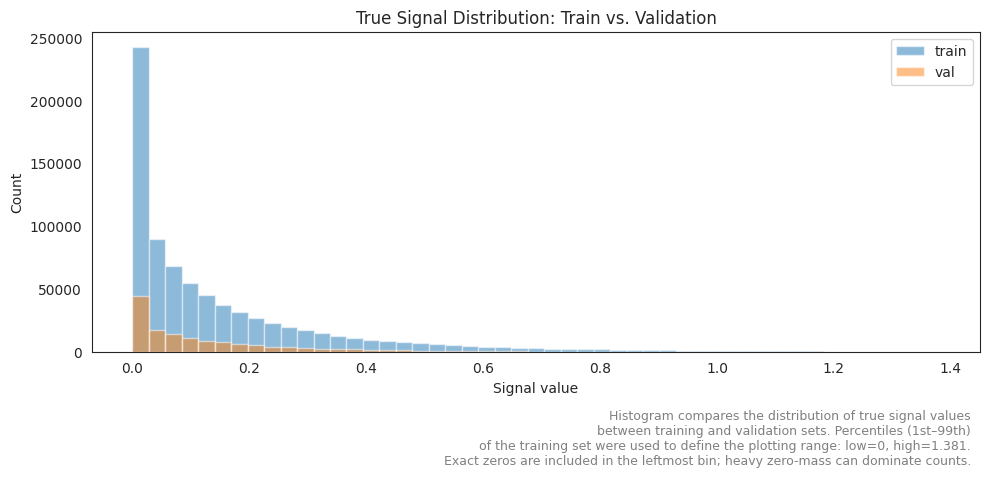

In [5]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

low, high = np.percentile(y_train, [1, 99])
bins = np.linspace(low, high, 50)   # zeros will be included in the leftmost bin if <= low

plt.figure(figsize=(10,5))
plt.hist(y_train, bins=bins, alpha=0.5, label="train")
plt.hist(y_val,   bins=bins, alpha=0.5, label="val")

# description / annotation
desc = (
    "Histogram compares the distribution of true signal values\n"
    "between training and validation sets. Percentiles (1st–99th)\n"
    f"of the training set were used to define the plotting range: low={low:.4g}, high={high:.4g}.\n"
    "Exact zeros are included in the leftmost bin; heavy zero-mass can dominate counts."
)
plt.title("True Signal Distribution: Train vs. Validation")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.legend()
plt.gca().text(
    0.99, -0.18, desc, ha="right", va="top", transform=plt.gca().transAxes,
    fontsize=9, color="gray"
)
plt.tight_layout()
plt.show()



In [6]:
# importlib.reload(models_custom) #############
# importlib.reload(params) #############

model = models_custom.ModelClass(
    n_feats             = len(params.features_cols_tick),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    look_back           = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.feature_names = params.features_cols_tick # for logging
model.to(params.device)  
print('Using:', params.device)
model

Using: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (input_proj): Linear(in_features=50, out_features=50, bias=True)
  (feature_proj): Linear(in_features=50, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
     

In [7]:
base_lr = params.hparams["ONECYCLE_MAX_LR"]
head_lr = base_lr * params.hparams["HEAD_LR_PCT"] # if we want to reduce the learning rate applied to the head

params_map = dict(model.named_parameters())
head_param = params_map["head_flat.2.bias"] # select the correct head name for the lr reduction
backbone_params = [p for n,p in params_map.items() if n != "head_flat.2.bias"]

optimizer = AdamW(
    [
        {"params": backbone_params, "lr": base_lr},
        {"params": [head_param],    "lr": head_lr},
    ],
    weight_decay = params.hparams["WEIGHT_DECAY"]
)


batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 1.9999999999999998e-05
    max_lr: 0.0002
    max_momentum: 0.95
    maximize: False
    min_lr: 2.0000000000000002e-07
    weight_decay: 2e-06

Parameter Group 1
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 1.9999999999999998e-05
    max_lr: 0.0002
    max_momentum: 0.95
    maximize: False
    min_lr: 2.0000000000000002e-07
    weight_decay: 2e-06
)

Training sees 896 unique trading days per epoch.

Model parameters: total=112,537, trainable=112,537

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 1, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 64, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 64, 'DROPOUT_SHORT': 0.1, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 64, 'TRANSFORMER_LAYERS': 2, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.03, 'USE_LONG_LSTM': False, 'LONG_UNITS': 64, 'DROPOUT_LONG': 0.1, 'FLATTEN_MODE': 'attn', 'PRED_HIDDEN': 96, 'ALPHA_SMOOTH': 0, 'WARMUP_STEPS': 3, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 90, 'EARLY_STOP_PATIENCE': 9, 'WEIGHT_DECAY': 2e-06, 'CLIPNORM': 2, 'ONECYCLE_MAX_LR': 0.0002, 'HEAD_LR_PCT': 1, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS':

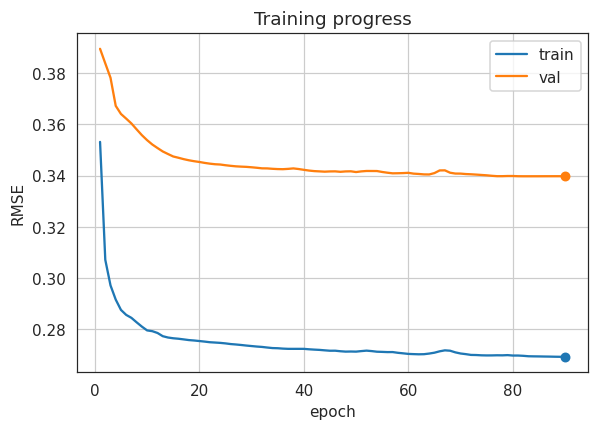

Epoch 1 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

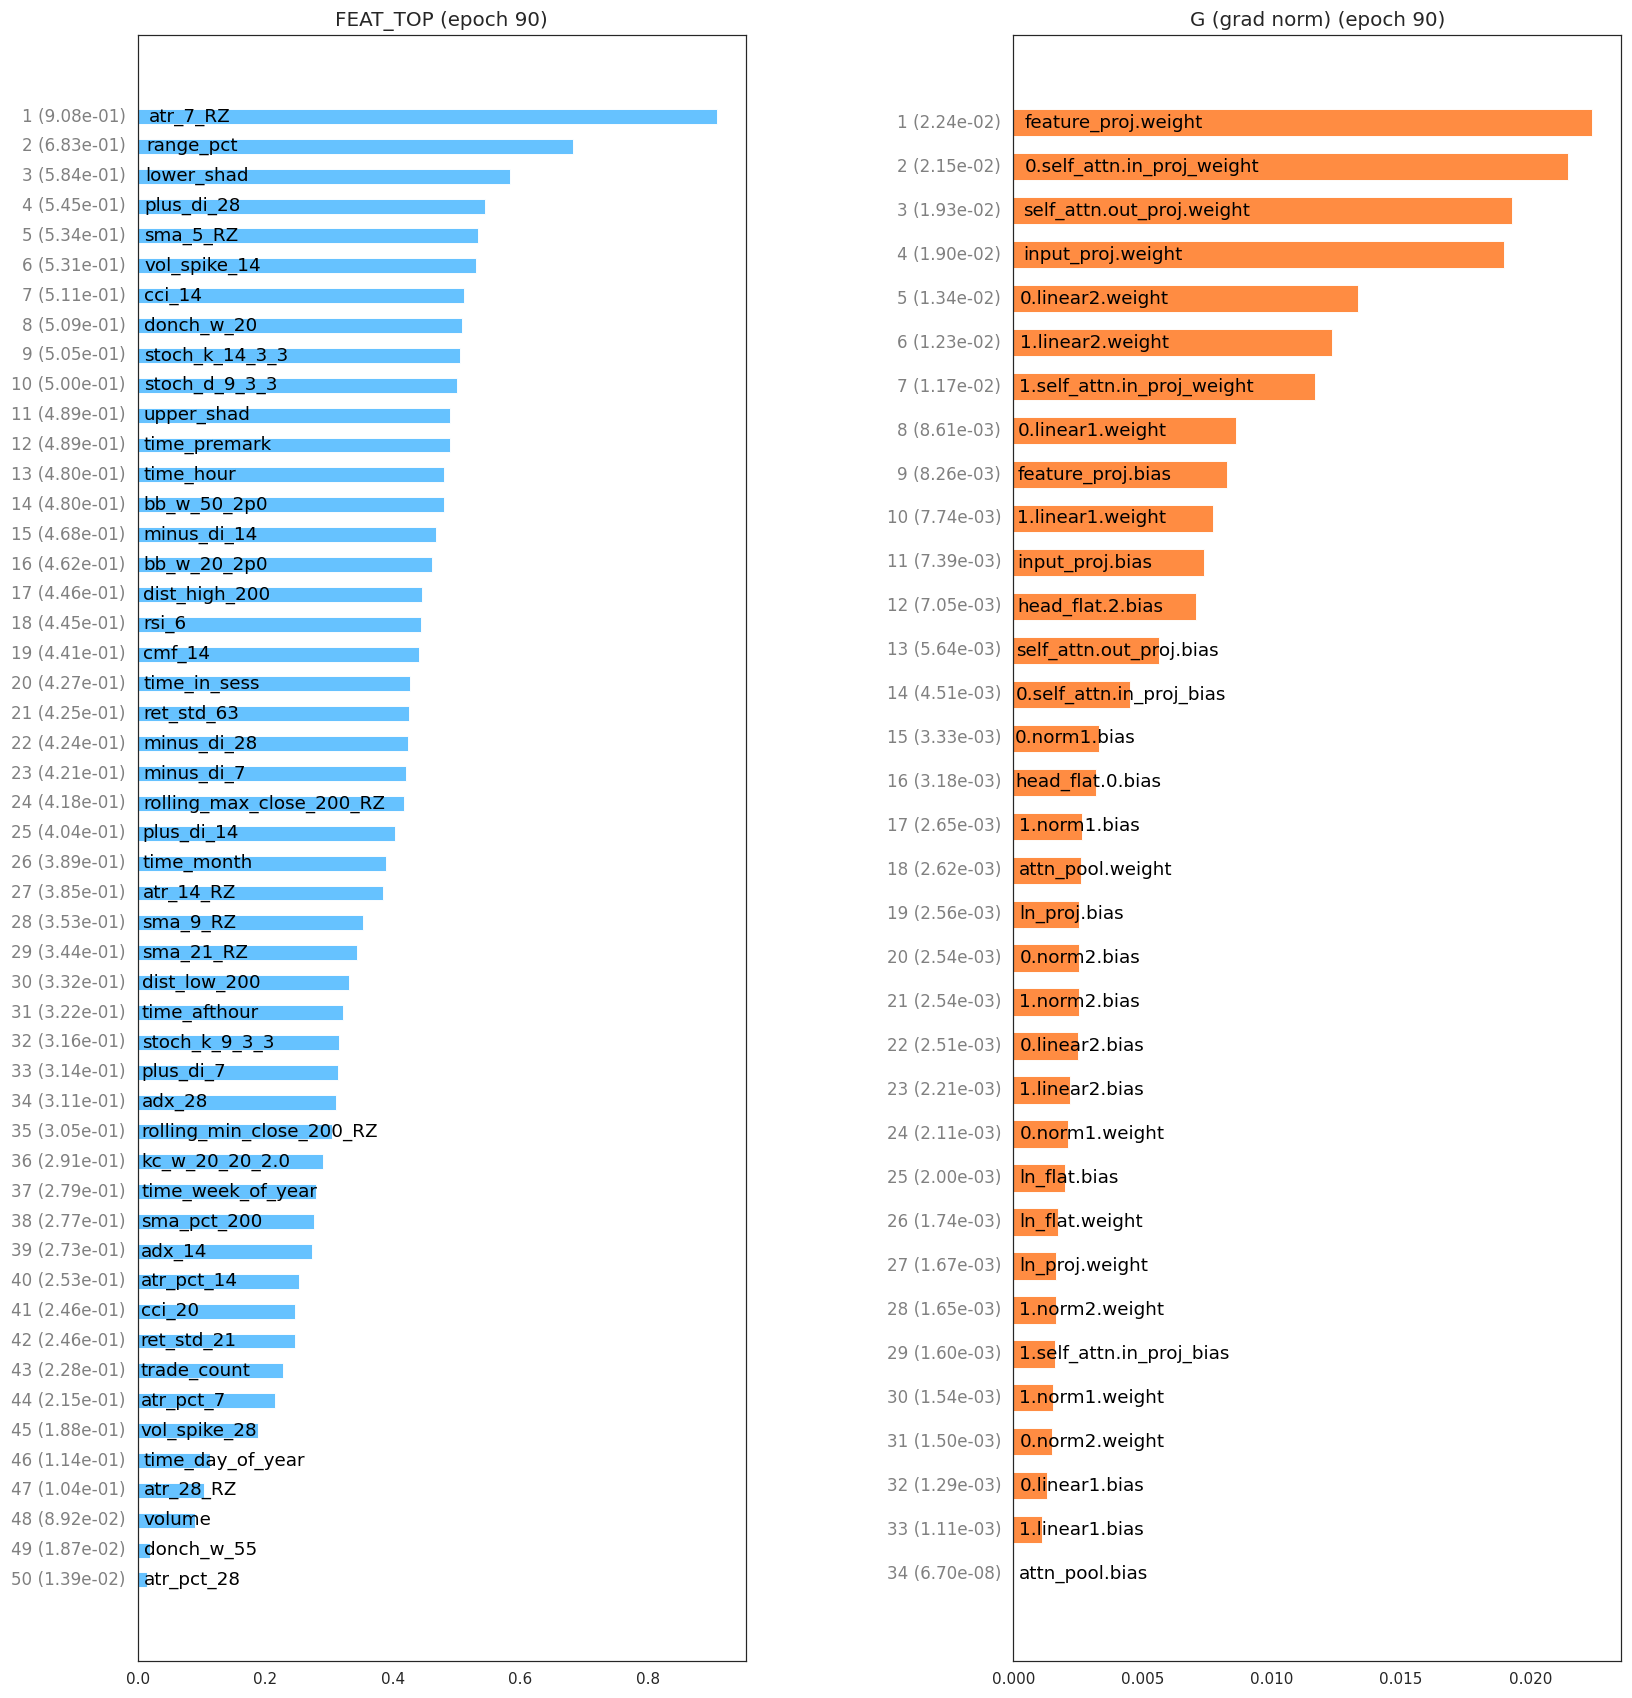

Epoch 01  TRAIN→ RMSE=0.35314, R²=-0.344 |  VALID→ RMSE=0.38948, R²=-0.001 |  lr=2.54e-05 |  loss=1.25049e-01 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/56 [00:05<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.30713, R²=-0.017 |  VALID→ RMSE=0.38379, R²=0.028 |  lr=4.11e-05 |  loss=9.45641e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.29713, R²=0.048 |  VALID→ RMSE=0.37818, R²=0.056 |  lr=6.52e-05 |  loss=8.85059e-02 |  improved=True


Epoch 4 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.29158, R²=0.083 |  VALID→ RMSE=0.36721, R²=0.110 |  lr=9.46e-05 |  loss=8.52336e-02 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.28755, R²=0.109 |  VALID→ RMSE=0.36405, R²=0.125 |  lr=1.26e-04 |  loss=8.28964e-02 |  improved=True


Epoch 6 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.28562, R²=0.121 |  VALID→ RMSE=0.36223, R²=0.134 |  lr=1.55e-04 |  loss=8.17749e-02 |  improved=True


Epoch 7 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.28446, R²=0.128 |  VALID→ RMSE=0.36034, R²=0.143 |  lr=1.79e-04 |  loss=8.11129e-02 |  improved=True


Epoch 8 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.28271, R²=0.138 |  VALID→ RMSE=0.35803, R²=0.154 |  lr=1.95e-04 |  loss=8.01188e-02 |  improved=True


Epoch 9 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.28104, R²=0.148 |  VALID→ RMSE=0.35577, R²=0.165 |  lr=2.00e-04 |  loss=7.91729e-02 |  improved=True


Epoch 10 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 10  TRAIN→ RMSE=0.27956, R²=0.157 |  VALID→ RMSE=0.35382, R²=0.174 |  lr=2.00e-04 |  loss=7.83383e-02 |  improved=True


Epoch 11 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 11  TRAIN→ RMSE=0.27925, R²=0.159 |  VALID→ RMSE=0.35212, R²=0.182 |  lr=2.00e-04 |  loss=7.81642e-02 |  improved=True


Epoch 12 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 12  TRAIN→ RMSE=0.27855, R²=0.164 |  VALID→ RMSE=0.35074, R²=0.188 |  lr=1.99e-04 |  loss=7.77738e-02 |  improved=True


Epoch 13 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 13  TRAIN→ RMSE=0.27730, R²=0.171 |  VALID→ RMSE=0.34941, R²=0.194 |  lr=1.99e-04 |  loss=7.70801e-02 |  improved=True


Epoch 14 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 14  TRAIN→ RMSE=0.27678, R²=0.174 |  VALID→ RMSE=0.34841, R²=0.199 |  lr=1.98e-04 |  loss=7.67917e-02 |  improved=True


Epoch 15 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 15  TRAIN→ RMSE=0.27649, R²=0.176 |  VALID→ RMSE=0.34745, R²=0.203 |  lr=1.97e-04 |  loss=7.66293e-02 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 16  TRAIN→ RMSE=0.27630, R²=0.177 |  VALID→ RMSE=0.34695, R²=0.205 |  lr=1.96e-04 |  loss=7.65283e-02 |  improved=True


Epoch 17 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 17  TRAIN→ RMSE=0.27605, R²=0.178 |  VALID→ RMSE=0.34641, R²=0.208 |  lr=1.95e-04 |  loss=7.63858e-02 |  improved=True


Epoch 18 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 18  TRAIN→ RMSE=0.27578, R²=0.180 |  VALID→ RMSE=0.34596, R²=0.210 |  lr=1.94e-04 |  loss=7.62382e-02 |  improved=True


Epoch 19 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 19  TRAIN→ RMSE=0.27562, R²=0.181 |  VALID→ RMSE=0.34560, R²=0.212 |  lr=1.93e-04 |  loss=7.61492e-02 |  improved=True


Epoch 20 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34531_chp.pth
Epoch 20  TRAIN→ RMSE=0.27541, R²=0.182 |  VALID→ RMSE=0.34531, R²=0.213 |  lr=1.91e-04 |  loss=7.60328e-02 |  improved=True


Epoch 21 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34495_chp.pth
Epoch 21  TRAIN→ RMSE=0.27519, R²=0.184 |  VALID→ RMSE=0.34495, R²=0.215 |  lr=1.89e-04 |  loss=7.59126e-02 |  improved=True


Epoch 22 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34465_chp.pth
Epoch 22  TRAIN→ RMSE=0.27494, R²=0.185 |  VALID→ RMSE=0.34465, R²=0.216 |  lr=1.88e-04 |  loss=7.57766e-02 |  improved=True


Epoch 23 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34442_chp.pth
Epoch 23  TRAIN→ RMSE=0.27482, R²=0.186 |  VALID→ RMSE=0.34442, R²=0.217 |  lr=1.86e-04 |  loss=7.57085e-02 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34431_chp.pth
Epoch 24  TRAIN→ RMSE=0.27469, R²=0.187 |  VALID→ RMSE=0.34431, R²=0.217 |  lr=1.84e-04 |  loss=7.56343e-02 |  improved=True


Epoch 25 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34403_chp.pth
Epoch 25  TRAIN→ RMSE=0.27449, R²=0.188 |  VALID→ RMSE=0.34403, R²=0.219 |  lr=1.81e-04 |  loss=7.55264e-02 |  improved=True


Epoch 26 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34380_chp.pth
Epoch 26  TRAIN→ RMSE=0.27423, R²=0.189 |  VALID→ RMSE=0.34380, R²=0.220 |  lr=1.79e-04 |  loss=7.53815e-02 |  improved=True


Epoch 27 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34360_chp.pth
Epoch 27  TRAIN→ RMSE=0.27406, R²=0.190 |  VALID→ RMSE=0.34360, R²=0.221 |  lr=1.77e-04 |  loss=7.52911e-02 |  improved=True


Epoch 28 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34348_chp.pth
Epoch 28  TRAIN→ RMSE=0.27386, R²=0.191 |  VALID→ RMSE=0.34348, R²=0.221 |  lr=1.74e-04 |  loss=7.51841e-02 |  improved=True


Epoch 29 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34339_chp.pth
Epoch 29  TRAIN→ RMSE=0.27364, R²=0.193 |  VALID→ RMSE=0.34339, R²=0.222 |  lr=1.71e-04 |  loss=7.50611e-02 |  improved=True


Epoch 30 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34323_chp.pth
Epoch 30  TRAIN→ RMSE=0.27345, R²=0.194 |  VALID→ RMSE=0.34323, R²=0.222 |  lr=1.69e-04 |  loss=7.49546e-02 |  improved=True


Epoch 31 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34304_chp.pth
Epoch 31  TRAIN→ RMSE=0.27326, R²=0.195 |  VALID→ RMSE=0.34304, R²=0.223 |  lr=1.66e-04 |  loss=7.48499e-02 |  improved=True


Epoch 32 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34282_chp.pth
Epoch 32  TRAIN→ RMSE=0.27310, R²=0.196 |  VALID→ RMSE=0.34282, R²=0.224 |  lr=1.63e-04 |  loss=7.47666e-02 |  improved=True


Epoch 33 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34279_chp.pth
Epoch 33  TRAIN→ RMSE=0.27287, R²=0.197 |  VALID→ RMSE=0.34279, R²=0.224 |  lr=1.60e-04 |  loss=7.46405e-02 |  improved=True


Epoch 34 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34264_chp.pth
Epoch 34  TRAIN→ RMSE=0.27266, R²=0.199 |  VALID→ RMSE=0.34264, R²=0.225 |  lr=1.57e-04 |  loss=7.45252e-02 |  improved=True


Epoch 35 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34253_chp.pth
Epoch 35  TRAIN→ RMSE=0.27260, R²=0.199 |  VALID→ RMSE=0.34253, R²=0.226 |  lr=1.53e-04 |  loss=7.44916e-02 |  improved=True


Epoch 36 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34249_chp.pth
Epoch 36  TRAIN→ RMSE=0.27245, R²=0.200 |  VALID→ RMSE=0.34249, R²=0.226 |  lr=1.50e-04 |  loss=7.44076e-02 |  improved=True


Epoch 37 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 37  TRAIN→ RMSE=0.27236, R²=0.200 |  VALID→ RMSE=0.34261, R²=0.225 |  lr=1.47e-04 |  loss=7.43597e-02 |  improved=False


Epoch 38 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 38  TRAIN→ RMSE=0.27235, R²=0.200 |  VALID→ RMSE=0.34279, R²=0.224 |  lr=1.43e-04 |  loss=7.43576e-02 |  improved=False


Epoch 39 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 39  TRAIN→ RMSE=0.27236, R²=0.200 |  VALID→ RMSE=0.34255, R²=0.225 |  lr=1.40e-04 |  loss=7.43592e-02 |  improved=False


Epoch 40 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34224_chp.pth
Epoch 40  TRAIN→ RMSE=0.27235, R²=0.200 |  VALID→ RMSE=0.34224, R²=0.227 |  lr=1.36e-04 |  loss=7.43571e-02 |  improved=True


Epoch 41 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34194_chp.pth
Epoch 41  TRAIN→ RMSE=0.27219, R²=0.201 |  VALID→ RMSE=0.34194, R²=0.228 |  lr=1.32e-04 |  loss=7.42667e-02 |  improved=True


Epoch 42 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34174_chp.pth
Epoch 42  TRAIN→ RMSE=0.27206, R²=0.202 |  VALID→ RMSE=0.34174, R²=0.229 |  lr=1.29e-04 |  loss=7.41961e-02 |  improved=True


Epoch 43 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34163_chp.pth
Epoch 43  TRAIN→ RMSE=0.27195, R²=0.203 |  VALID→ RMSE=0.34163, R²=0.230 |  lr=1.25e-04 |  loss=7.41369e-02 |  improved=True


Epoch 44 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34152_chp.pth
Epoch 44  TRAIN→ RMSE=0.27178, R²=0.204 |  VALID→ RMSE=0.34152, R²=0.230 |  lr=1.21e-04 |  loss=7.40432e-02 |  improved=True


Epoch 45 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 45  TRAIN→ RMSE=0.27162, R²=0.205 |  VALID→ RMSE=0.34161, R²=0.230 |  lr=1.17e-04 |  loss=7.39569e-02 |  improved=False


Epoch 46 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 46  TRAIN→ RMSE=0.27163, R²=0.205 |  VALID→ RMSE=0.34164, R²=0.230 |  lr=1.14e-04 |  loss=7.39643e-02 |  improved=False


Epoch 47 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34146_chp.pth
Epoch 47  TRAIN→ RMSE=0.27142, R²=0.206 |  VALID→ RMSE=0.34146, R²=0.230 |  lr=1.10e-04 |  loss=7.38498e-02 |  improved=True


Epoch 48 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 48  TRAIN→ RMSE=0.27128, R²=0.207 |  VALID→ RMSE=0.34162, R²=0.230 |  lr=1.06e-04 |  loss=7.37695e-02 |  improved=False


Epoch 49 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 49  TRAIN→ RMSE=0.27132, R²=0.206 |  VALID→ RMSE=0.34166, R²=0.229 |  lr=1.02e-04 |  loss=7.37908e-02 |  improved=False


Epoch 50 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34137_chp.pth
Epoch 50  TRAIN→ RMSE=0.27127, R²=0.207 |  VALID→ RMSE=0.34137, R²=0.231 |  lr=9.81e-05 |  loss=7.37660e-02 |  improved=True


Epoch 51 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 51  TRAIN→ RMSE=0.27148, R²=0.205 |  VALID→ RMSE=0.34163, R²=0.230 |  lr=9.42e-05 |  loss=7.38794e-02 |  improved=False


Epoch 52 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 52  TRAIN→ RMSE=0.27166, R²=0.204 |  VALID→ RMSE=0.34179, R²=0.229 |  lr=9.04e-05 |  loss=7.39754e-02 |  improved=False


Epoch 53 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 53  TRAIN→ RMSE=0.27148, R²=0.205 |  VALID→ RMSE=0.34178, R²=0.229 |  lr=8.65e-05 |  loss=7.38790e-02 |  improved=False


Epoch 54 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 54  TRAIN→ RMSE=0.27124, R²=0.207 |  VALID→ RMSE=0.34176, R²=0.229 |  lr=8.27e-05 |  loss=7.37484e-02 |  improved=False


Epoch 55 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 55  TRAIN→ RMSE=0.27117, R²=0.207 |  VALID→ RMSE=0.34140, R²=0.231 |  lr=7.89e-05 |  loss=7.37137e-02 |  improved=False


Epoch 56 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34111_chp.pth
Epoch 56  TRAIN→ RMSE=0.27109, R²=0.208 |  VALID→ RMSE=0.34111, R²=0.232 |  lr=7.51e-05 |  loss=7.36683e-02 |  improved=True


Epoch 57 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34087_chp.pth
Epoch 57  TRAIN→ RMSE=0.27110, R²=0.208 |  VALID→ RMSE=0.34087, R²=0.233 |  lr=7.14e-05 |  loss=7.36769e-02 |  improved=True


Epoch 58 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 58  TRAIN→ RMSE=0.27081, R²=0.209 |  VALID→ RMSE=0.34090, R²=0.233 |  lr=6.77e-05 |  loss=7.35203e-02 |  improved=False


Epoch 59 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 59  TRAIN→ RMSE=0.27061, R²=0.211 |  VALID→ RMSE=0.34096, R²=0.233 |  lr=6.41e-05 |  loss=7.34078e-02 |  improved=False


Epoch 60 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 60  TRAIN→ RMSE=0.27038, R²=0.212 |  VALID→ RMSE=0.34107, R²=0.232 |  lr=6.05e-05 |  loss=7.32862e-02 |  improved=False


Epoch 61 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34075_chp.pth
Epoch 61  TRAIN→ RMSE=0.27030, R²=0.212 |  VALID→ RMSE=0.34075, R²=0.234 |  lr=5.69e-05 |  loss=7.32403e-02 |  improved=True


Epoch 62 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34062_chp.pth
Epoch 62  TRAIN→ RMSE=0.27023, R²=0.213 |  VALID→ RMSE=0.34062, R²=0.234 |  lr=5.35e-05 |  loss=7.32030e-02 |  improved=True


Epoch 63 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34045_chp.pth
Epoch 63  TRAIN→ RMSE=0.27027, R²=0.212 |  VALID→ RMSE=0.34045, R²=0.235 |  lr=5.01e-05 |  loss=7.32254e-02 |  improved=True


Epoch 64 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34043_chp.pth
Epoch 64  TRAIN→ RMSE=0.27052, R²=0.211 |  VALID→ RMSE=0.34043, R²=0.235 |  lr=4.68e-05 |  loss=7.33585e-02 |  improved=True


Epoch 65 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 65  TRAIN→ RMSE=0.27086, R²=0.209 |  VALID→ RMSE=0.34097, R²=0.233 |  lr=4.35e-05 |  loss=7.35429e-02 |  improved=False


Epoch 66 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 66  TRAIN→ RMSE=0.27140, R²=0.206 |  VALID→ RMSE=0.34200, R²=0.228 |  lr=4.04e-05 |  loss=7.38372e-02 |  improved=False


Epoch 67 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 67  TRAIN→ RMSE=0.27177, R²=0.204 |  VALID→ RMSE=0.34203, R²=0.228 |  lr=3.73e-05 |  loss=7.40440e-02 |  improved=False


Epoch 68 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 68  TRAIN→ RMSE=0.27163, R²=0.205 |  VALID→ RMSE=0.34110, R²=0.232 |  lr=3.44e-05 |  loss=7.39630e-02 |  improved=False


Epoch 69 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 69  TRAIN→ RMSE=0.27099, R²=0.208 |  VALID→ RMSE=0.34078, R²=0.233 |  lr=3.15e-05 |  loss=7.36128e-02 |  improved=False


Epoch 70 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 70  TRAIN→ RMSE=0.27054, R²=0.211 |  VALID→ RMSE=0.34076, R²=0.234 |  lr=2.87e-05 |  loss=7.33715e-02 |  improved=False


Epoch 71 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 71  TRAIN→ RMSE=0.27029, R²=0.212 |  VALID→ RMSE=0.34059, R²=0.234 |  lr=2.61e-05 |  loss=7.32362e-02 |  improved=False


Epoch 72 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 72  TRAIN→ RMSE=0.26999, R²=0.214 |  VALID→ RMSE=0.34050, R²=0.235 |  lr=2.35e-05 |  loss=7.30707e-02 |  improved=False


Epoch 73 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34037_chp.pth
Epoch 73  TRAIN→ RMSE=0.26995, R²=0.214 |  VALID→ RMSE=0.34037, R²=0.235 |  lr=2.11e-05 |  loss=7.30485e-02 |  improved=True


Epoch 74 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34023_chp.pth
Epoch 74  TRAIN→ RMSE=0.26983, R²=0.215 |  VALID→ RMSE=0.34023, R²=0.236 |  lr=1.88e-05 |  loss=7.29867e-02 |  improved=True


Epoch 75 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.34010_chp.pth
Epoch 75  TRAIN→ RMSE=0.26979, R²=0.215 |  VALID→ RMSE=0.34010, R²=0.237 |  lr=1.66e-05 |  loss=7.29636e-02 |  improved=True


Epoch 76 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.33990_chp.pth
Epoch 76  TRAIN→ RMSE=0.26980, R²=0.215 |  VALID→ RMSE=0.33990, R²=0.237 |  lr=1.45e-05 |  loss=7.29687e-02 |  improved=True


Epoch 77 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.33976_chp.pth
Epoch 77  TRAIN→ RMSE=0.26985, R²=0.215 |  VALID→ RMSE=0.33976, R²=0.238 |  lr=1.26e-05 |  loss=7.29951e-02 |  improved=True


Epoch 78 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 78  TRAIN→ RMSE=0.26982, R²=0.215 |  VALID→ RMSE=0.33976, R²=0.238 |  lr=1.08e-05 |  loss=7.29811e-02 |  improved=False


Epoch 79 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 79  TRAIN→ RMSE=0.26991, R²=0.215 |  VALID→ RMSE=0.33982, R²=0.238 |  lr=9.13e-06 |  loss=7.30293e-02 |  improved=False


Epoch 80 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 80  TRAIN→ RMSE=0.26974, R²=0.216 |  VALID→ RMSE=0.33982, R²=0.238 |  lr=7.59e-06 |  loss=7.29394e-02 |  improved=False


Epoch 81 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.33974_chp.pth
Epoch 81  TRAIN→ RMSE=0.26975, R²=0.216 |  VALID→ RMSE=0.33974, R²=0.238 |  lr=6.20e-06 |  loss=7.29427e-02 |  improved=True


Epoch 82 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.33972_chp.pth
Epoch 82  TRAIN→ RMSE=0.26964, R²=0.216 |  VALID→ RMSE=0.33972, R²=0.238 |  lr=4.95e-06 |  loss=7.28826e-02 |  improved=True


Epoch 83 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 83  TRAIN→ RMSE=0.26947, R²=0.217 |  VALID→ RMSE=0.33972, R²=0.238 |  lr=3.84e-06 |  loss=7.27920e-02 |  improved=True


Epoch 84 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 84  TRAIN→ RMSE=0.26943, R²=0.217 |  VALID→ RMSE=0.33973, R²=0.238 |  lr=2.88e-06 |  loss=7.27689e-02 |  improved=False


Epoch 85 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 85  TRAIN→ RMSE=0.26940, R²=0.218 |  VALID→ RMSE=0.33973, R²=0.238 |  lr=2.06e-06 |  loss=7.27550e-02 |  improved=False


Epoch 86 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 86  TRAIN→ RMSE=0.26936, R²=0.218 |  VALID→ RMSE=0.33974, R²=0.238 |  lr=1.39e-06 |  loss=7.27334e-02 |  improved=False


Epoch 87 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 87  TRAIN→ RMSE=0.26933, R²=0.218 |  VALID→ RMSE=0.33974, R²=0.238 |  lr=8.67e-07 |  loss=7.27181e-02 |  improved=False


Epoch 88 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 88  TRAIN→ RMSE=0.26929, R²=0.218 |  VALID→ RMSE=0.33974, R²=0.238 |  lr=4.95e-07 |  loss=7.26930e-02 |  improved=False


Epoch 89 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 89  TRAIN→ RMSE=0.26926, R²=0.218 |  VALID→ RMSE=0.33975, R²=0.238 |  lr=2.72e-07 |  loss=7.26769e-02 |  improved=False


Epoch 90 ▶ Train:   0%|          | 0/56 [00:00<?, ?it/s]

eval:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 90  TRAIN→ RMSE=0.26932, R²=0.218 |  VALID→ RMSE=0.33975, R²=0.238 |  lr=2.00e-07 |  loss=7.27111e-02 |  improved=False
✅ Final‐best model saved: AAPL_0.33972_fin.pth


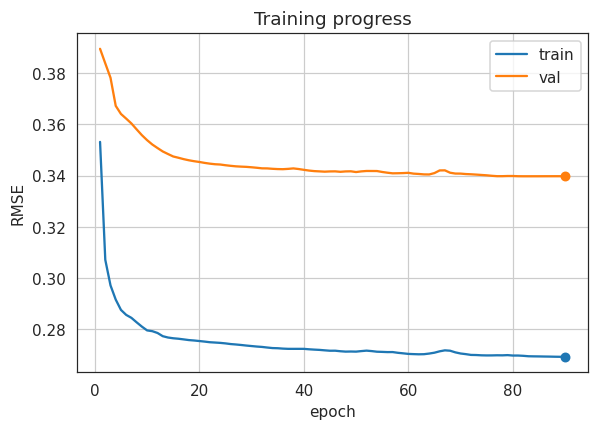

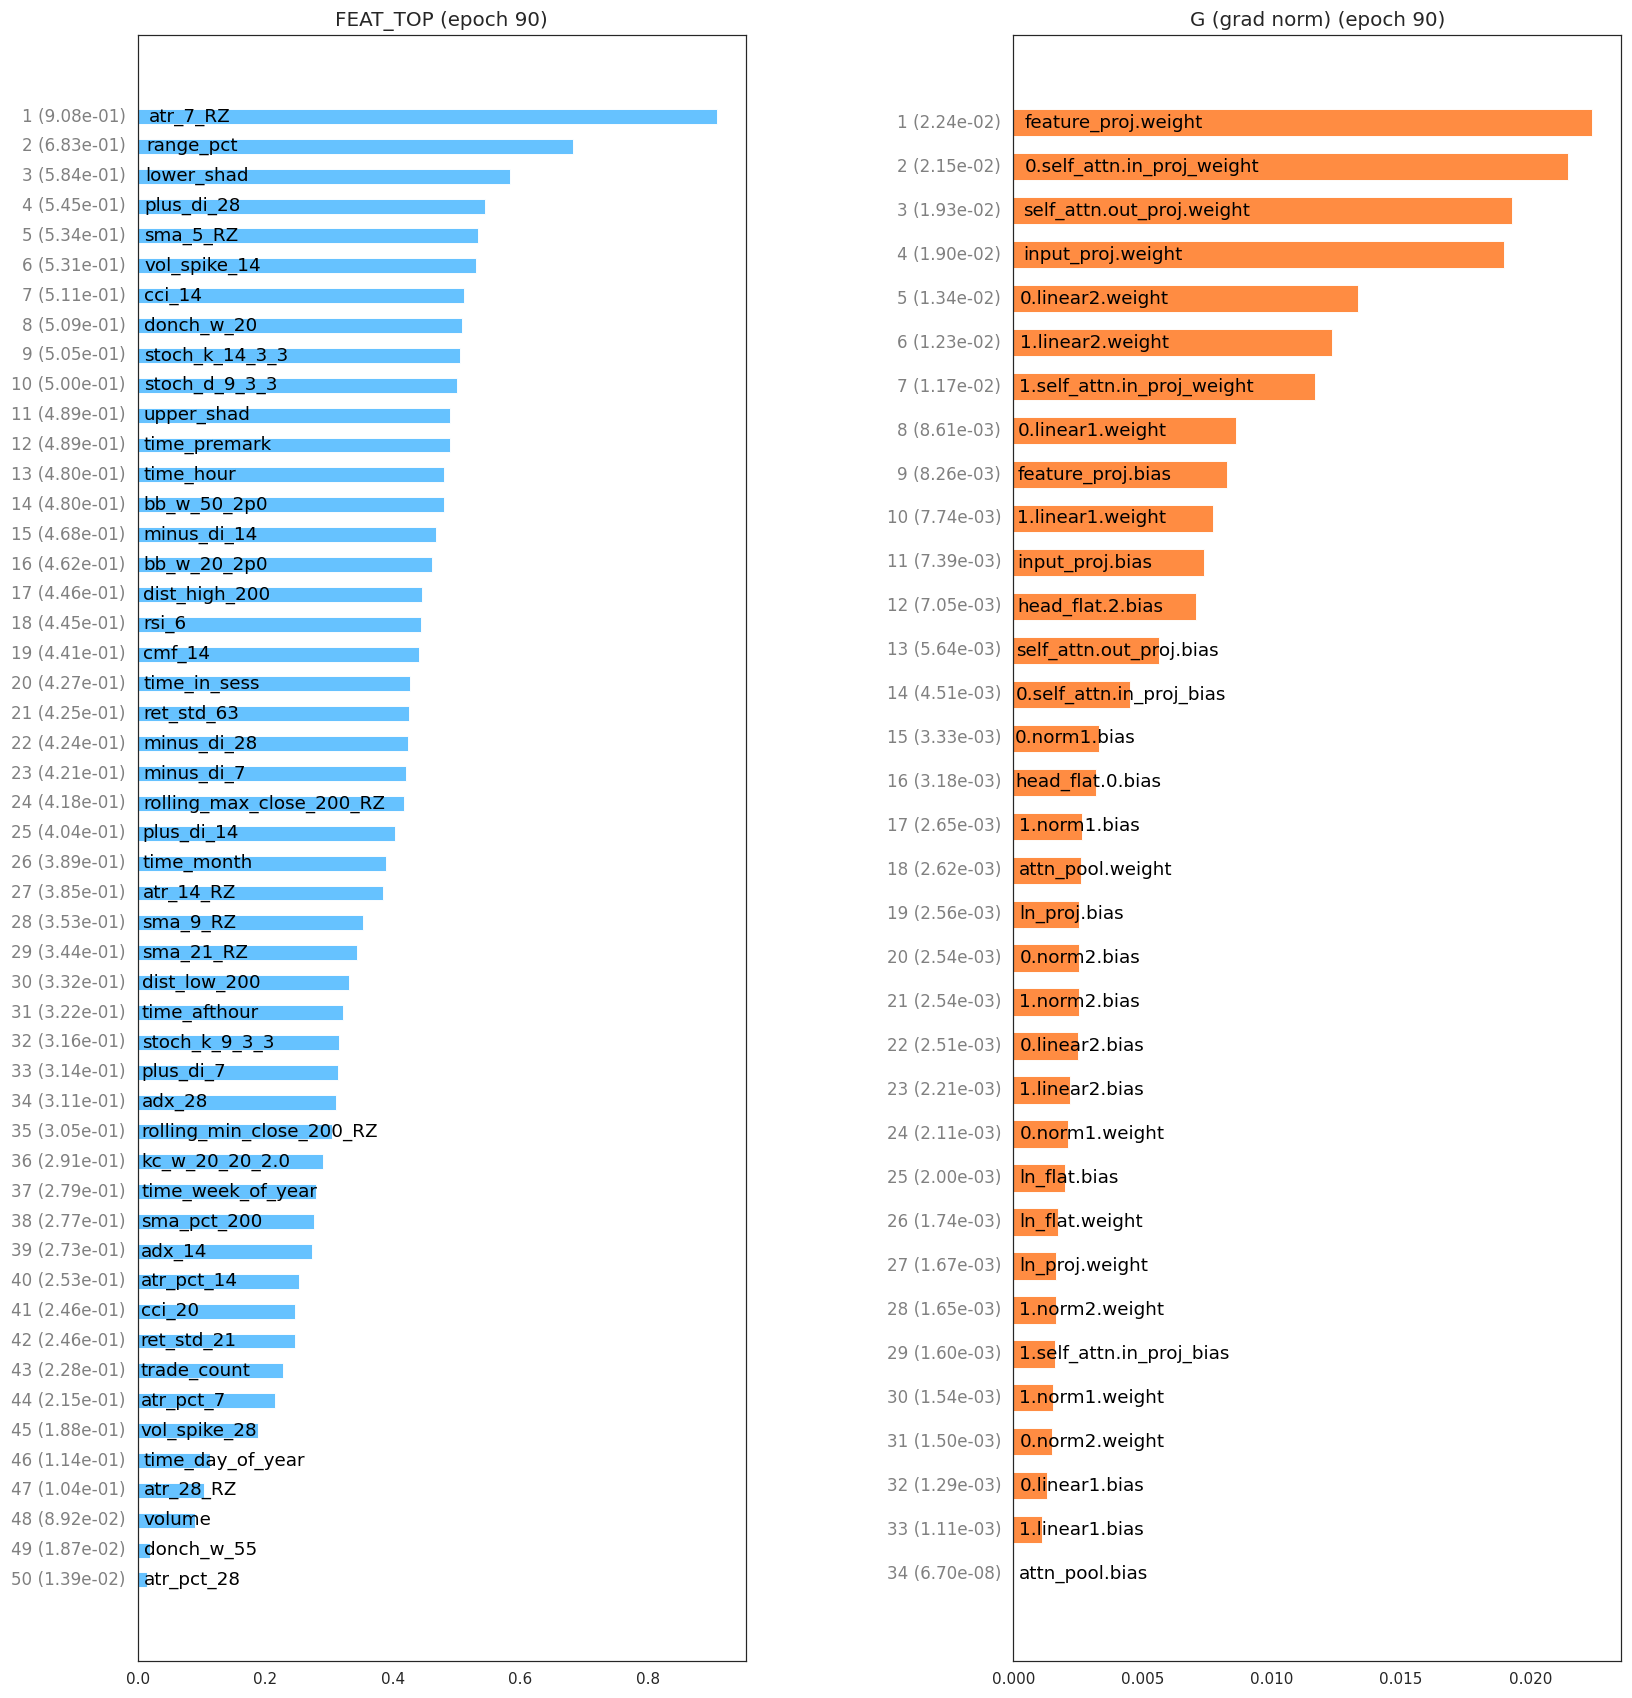

In [8]:
# importlib.reload(models_custom) #############
importlib.reload(params) #############

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader
)